# Example Interrupted Time Series (ITS) with `pymc` models

This notebook shows an example of using interrupted time series, where we do not have untreated control units of a similar nature to the treated unit and we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Interrupted Time Series (ITS) Example

Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not neccessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.pymc_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


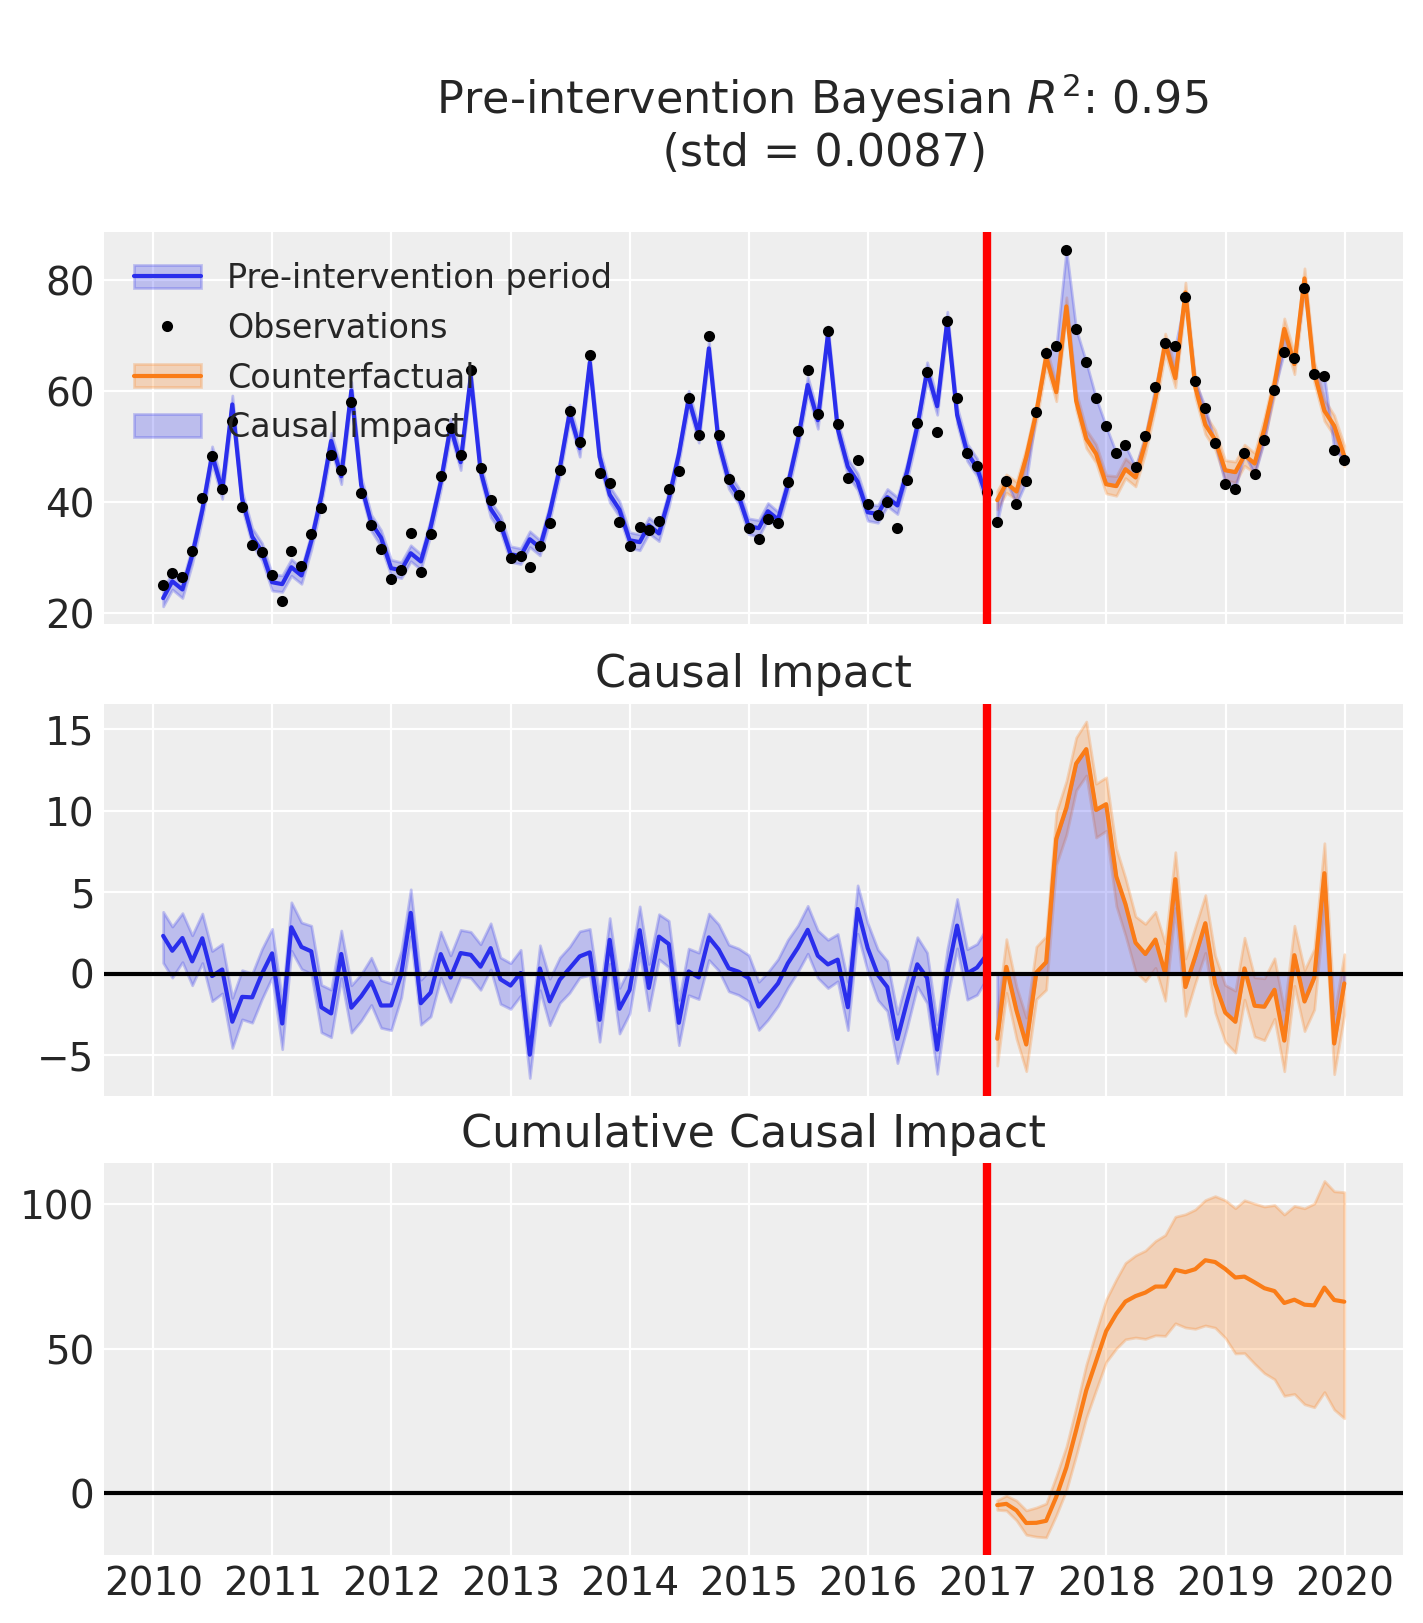

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
Intercept                     22.74, 94% HDI [21.18, 24.32]
C(month)[T.2]                 2.84, 94% HDI [0.76, 4.83]
C(month)[T.3]                 1.14, 94% HDI [-0.87, 3.10]
C(month)[T.4]                 7.12, 94% HDI [5.06, 9.13]
C(month)[T.5]                 15.00, 94% HDI [12.96, 17.00]
C(month)[T.6]                 24.76, 94% HDI [22.74, 26.81]
C(month)[T.7]                 18.19, 94% HDI [16.12, 20.12]
C(month)[T.8]                 33.43, 94% HDI [31.44, 35.47]
C(month)[T.9]                 16.21, 94% HDI [14.14, 18.19]
C(month)[T.10]                9.17, 94% HDI [7.20, 11.22]
C(month)[T.11]                6.26, 94% HDI [4.24, 8.31]
C(month)[T.12]                0.55, 94% HDI [-1.47, 2.55]
t                             0.21, 94% HDI [0.19, 0.23]
sigma                         1.97, 94% HDI [1.69, 2.27]


As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [7]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.843,0.586,0.723,2.896,0.011,0.008,2764.0,3064.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [8]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,66.356,21.101,26.034,104.273,0.4,0.286,2764.0,3064.0,1.0
